In [1]:
# To embed plots in the notebooks
import warnings
warnings.filterwarnings("ignore")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                              AdaBoostRegressor)
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xlrd
import pandas as pd # pandas library
import numpy as np # numpy library
import warnings
from io import StringIO # to obtain string values from text
import scipy . linalg as lng # linear algebra from scipy library
from scipy . spatial import distance # load distance function
from sklearn import preprocessing as preproc # load preprocessing function
from sklearn.impute import SimpleImputer # load simpleimputer function for floats
# from fancyimpute import IterativeImputer, SoftImpute
from sklearn.preprocessing import LabelEncoder # load labelencoder to encode categorical data
from sklearn.linear_model import ElasticNet, Ridge, LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import explained_variance_score
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

# For running R code 
%load_ext rpy2.ipython

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/My\ Drive

Mounted at /content/gdrive
/content/gdrive/My Drive


Loading Data (Pre-processing done in CV Folds)

In [3]:
# Load the data
case1Path = './Comp Data Analysis/Case 1/case1Data.txt'
df = pd.read_csv(case1Path, na_values=['NA',' NaN','NaN','nan','n.a.'], low_memory=False)

# Get the target variable and continuous features
y = df.iloc[:, 0]
X_cont = df.iloc[:, 1:96]

# Get the categorical features and select the last 5 columns
X_categ = df.iloc[:, 96:101]

# Combine the continuous and categorical features
X = pd.concat([X_cont, X_categ], axis=1)

Missing Data Analysis (Code in R)

In [ ]:
%%R
# Load libraries 
library(mice)
library(naniar)
library(Amelia)
library(dplyr)
library(VIM)
library(vcd)
library(miceadds)
library(jomo)

# Load the data
case1Path <- "case1Data.txt"
df <- read.csv(case1Path, header = TRUE)

# Convert categorical variables to factors and replace "NaN" levels with NA
X_cat <- data.frame(lapply(df[, 97:101], function(x) {
  x <- gsub("NaN", NA, x)
  factor(x)
}))

# Calculate percentage of missing values
miss_percent <- mean(is.na(df)) * 100

# Identify missing values in continuous variables
X_cont <- df[, 2:96]
X_cont[is.na(X_cont)] <- NA

# Get the target variable
y <- df[, 1]

# Visualize missing data
par(mfrow=c(1,2)) # create 2 panels side by side
md.pattern(X_cont) 
aggr(X_cont) 

# Check for constant variables
md.pattern(X_cat) 

# Print missing value percentage
cat("Percentage of missing values in the dataset:", round(miss_percent, 2), "%")

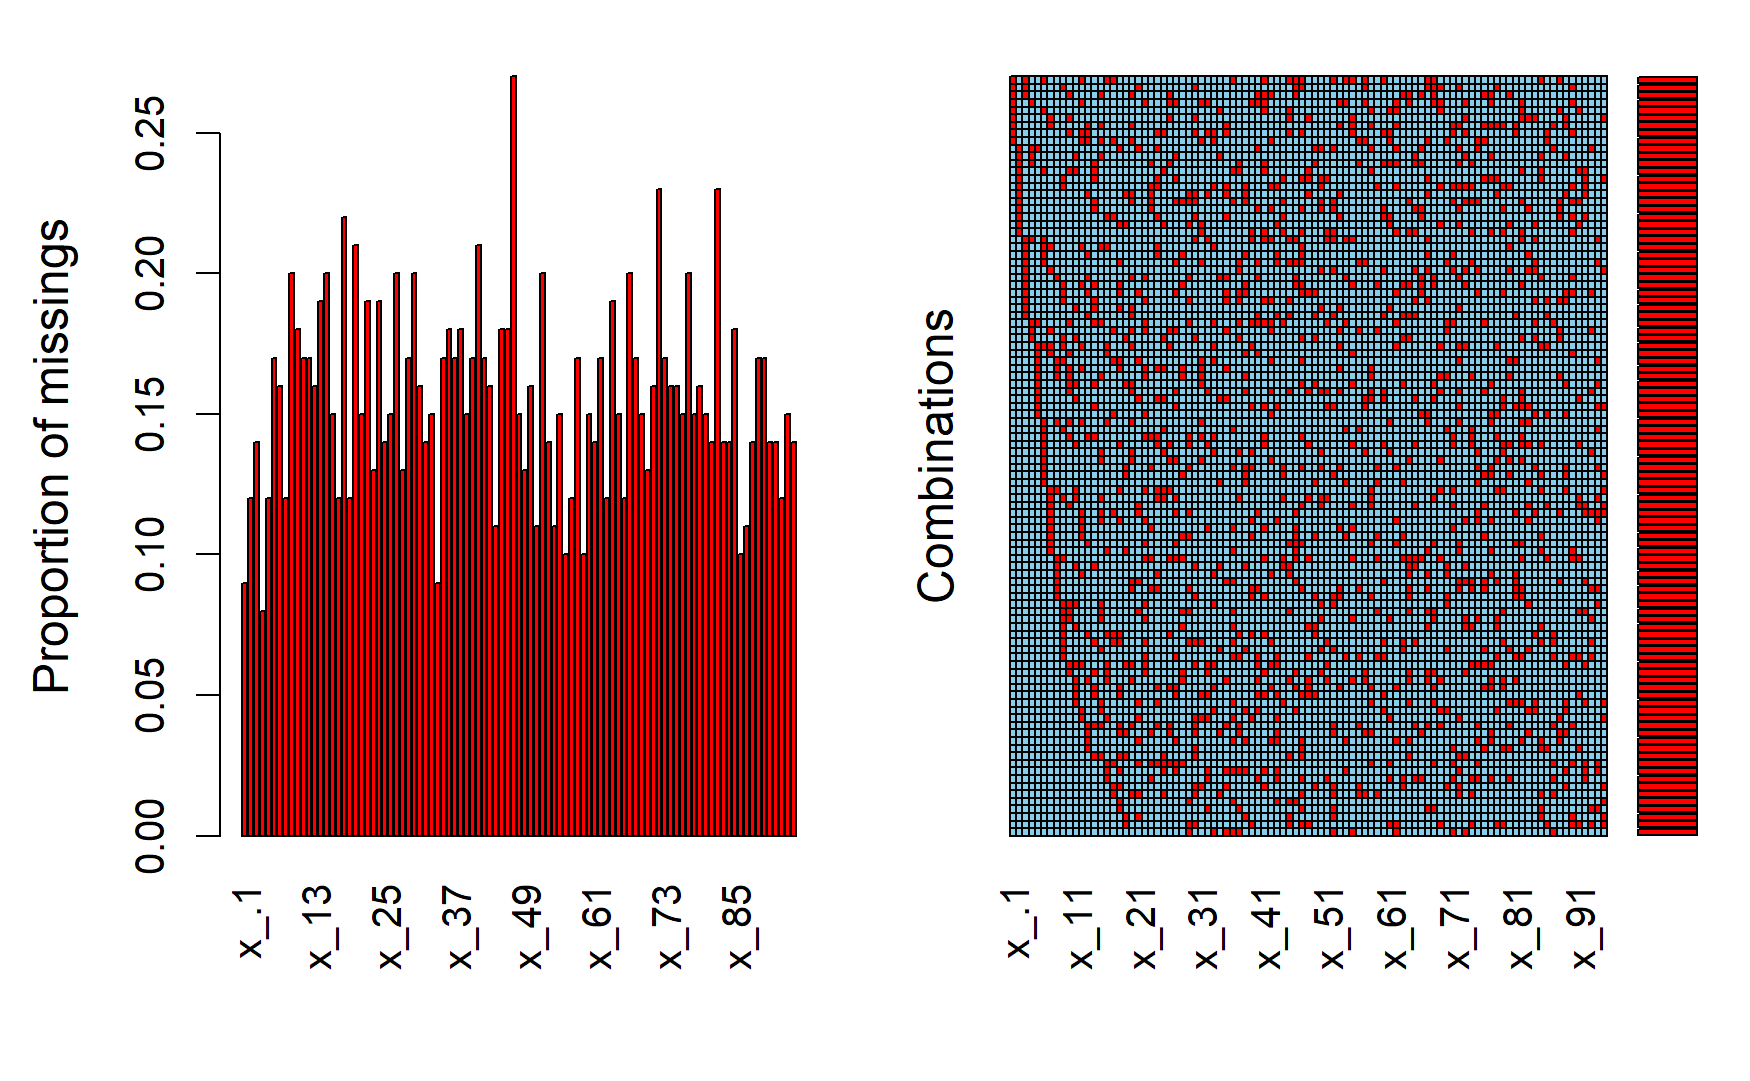

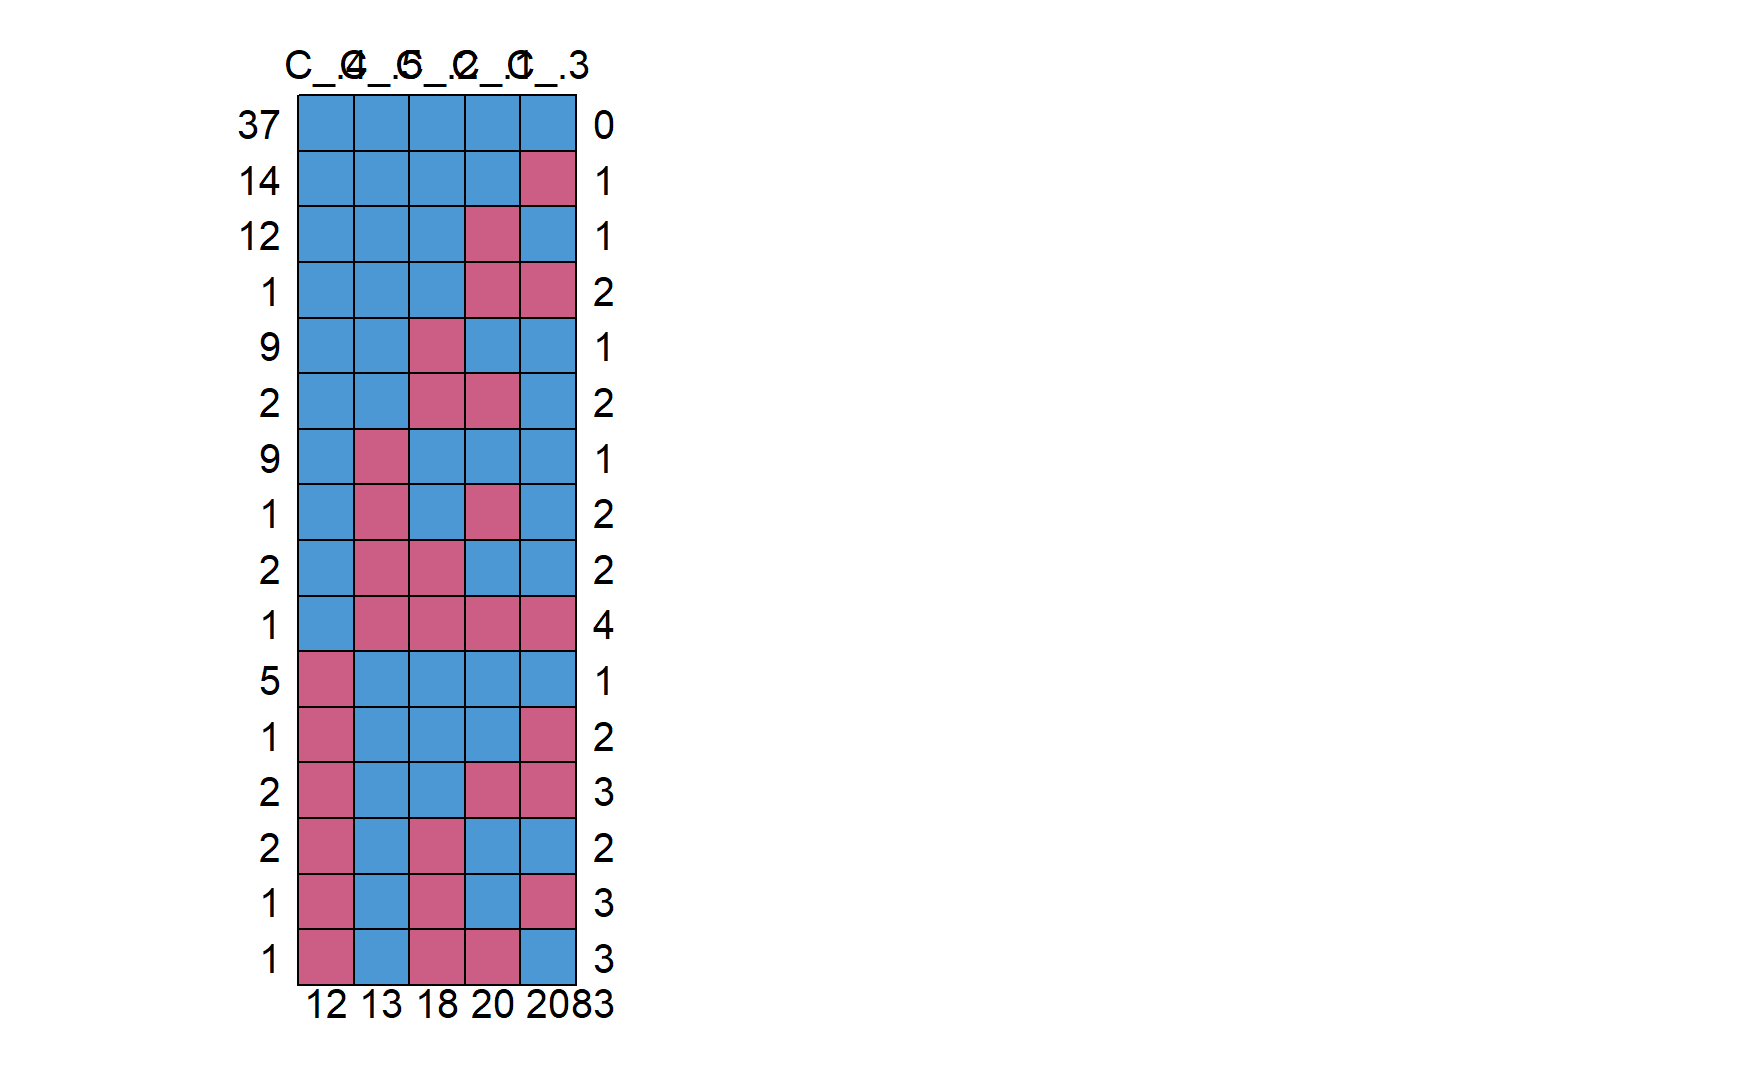

Data Visualization (Imputed Data only for Correlation Matrix, Actually Imputation occurs in CV Folds)

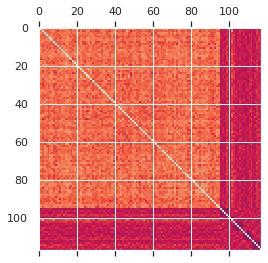

(117, 117)


In [ ]:
# Load the data
case1Path = './Comp Data Analysis/Case 1/case1Data.txt'
df = pd.read_csv(case1Path, na_values=['NA',' NaN','nan','n.a.'], low_memory=False)

# Get the target variable and continuous features
y = df.iloc[:, 0]
X_cont = df.iloc[:, 1:96]

# Get the categorical features and select the last 5 columns
X_categ = df.iloc[:, 96:101]

# Define SimpleImputer to fill in missing values for continuous data with mean value and one-hot encoded categorical data with mode
continuous_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# Fit and transform SimpleImputer on continuous and categorical data
X_continuous = continuous_imputer.fit_transform(X_cont)
X_categorical = categorical_imputer.fit_transform(X_categ)

# One hot encode categorical data
encoder = OneHotEncoder()
X_categ_encoded = encoder.fit_transform(X_categorical)
X_categ_encoded_df = pd.DataFrame(X_categ_encoded.toarray())

# Concatenate the continuous and categorical data back together
X_imputed = np.concatenate([X_continuous, X_categ_encoded.toarray()], axis=1)

# Convert the imputed data back to a DataFrame
X_visual = pd.DataFrame(X_imputed)

corr_matrix = X_visual.corr()
plt.matshow(corr_matrix)
plt.show()
print(corr_matrix.shape)

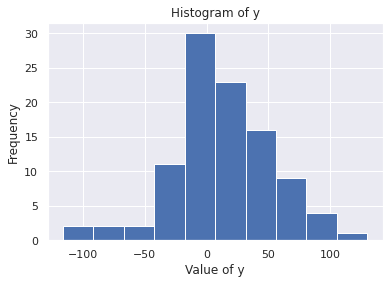

In [ ]:
# Check that y is normally distributed to ensure usage of linear regression is appropriate or further transformation needed
# Plot the histogram
plt.hist(y)

# Add a title and axis labels
plt.title("Histogram of y")
plt.xlabel("Value of y")
plt.ylabel("Frequency")

# Show the plot
plt.show()

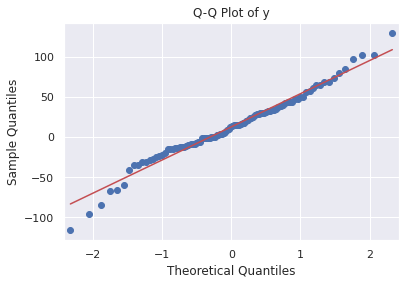

In [ ]:
# Create Q-Q plot
sm.qqplot(y, line='s')

# Add a title
plt.title("Q-Q Plot of y")

# Show the plot
plt.show()

Linear Model & Residual Plot Analysis (Code in R)

In [ ]:
%%R
library(caret)
library(Hmisc)

# Load the data
case1Path <- "case1Data.txt"
df <- read.csv(case1Path, na.strings=c('NA', 'NaN', 'nan', 'n.a.'), header=TRUE, stringsAsFactors=FALSE)

# Get the target variable and continuous features
y <- df[, 1]
X_cont <- df[, 2:96]

# Get the categorical features and select the last 5 columns
X_categ <- df[, 97:101]

# Convert categorical variables to factors and replace "NaN" levels with NA
X_categ <- data.frame(lapply(df[, 97:101], function(x) {
  x <- gsub("NaN", NA, x)
  factor(x)
}))

# Manually impute missing values for continuous data with mean value and categorical data with mode
for (i in 1:ncol(X_cont)) {
  col_mean <- mean(X_cont[,i], na.rm=TRUE)
  X_cont[is.na(X_cont[,i]),i] <- col_mean
}

for (i in 1:ncol(X_categ)) {
  col_mode <- names(sort(table(X_categ[,i]), decreasing=TRUE))[1]
  X_categ[is.na(X_categ[,i]),i] <- col_mode
  X_categ[,i] <- as.numeric(as.factor(X_categ[,i]))
}

# Combine the continuous and categorical features
X <- cbind(X_cont, X_categ)

# Fit linear model
model <- lm(y ~ ., data = X_cont)

# Plot model results
par(mfrow=c(2,2))
plot(model)

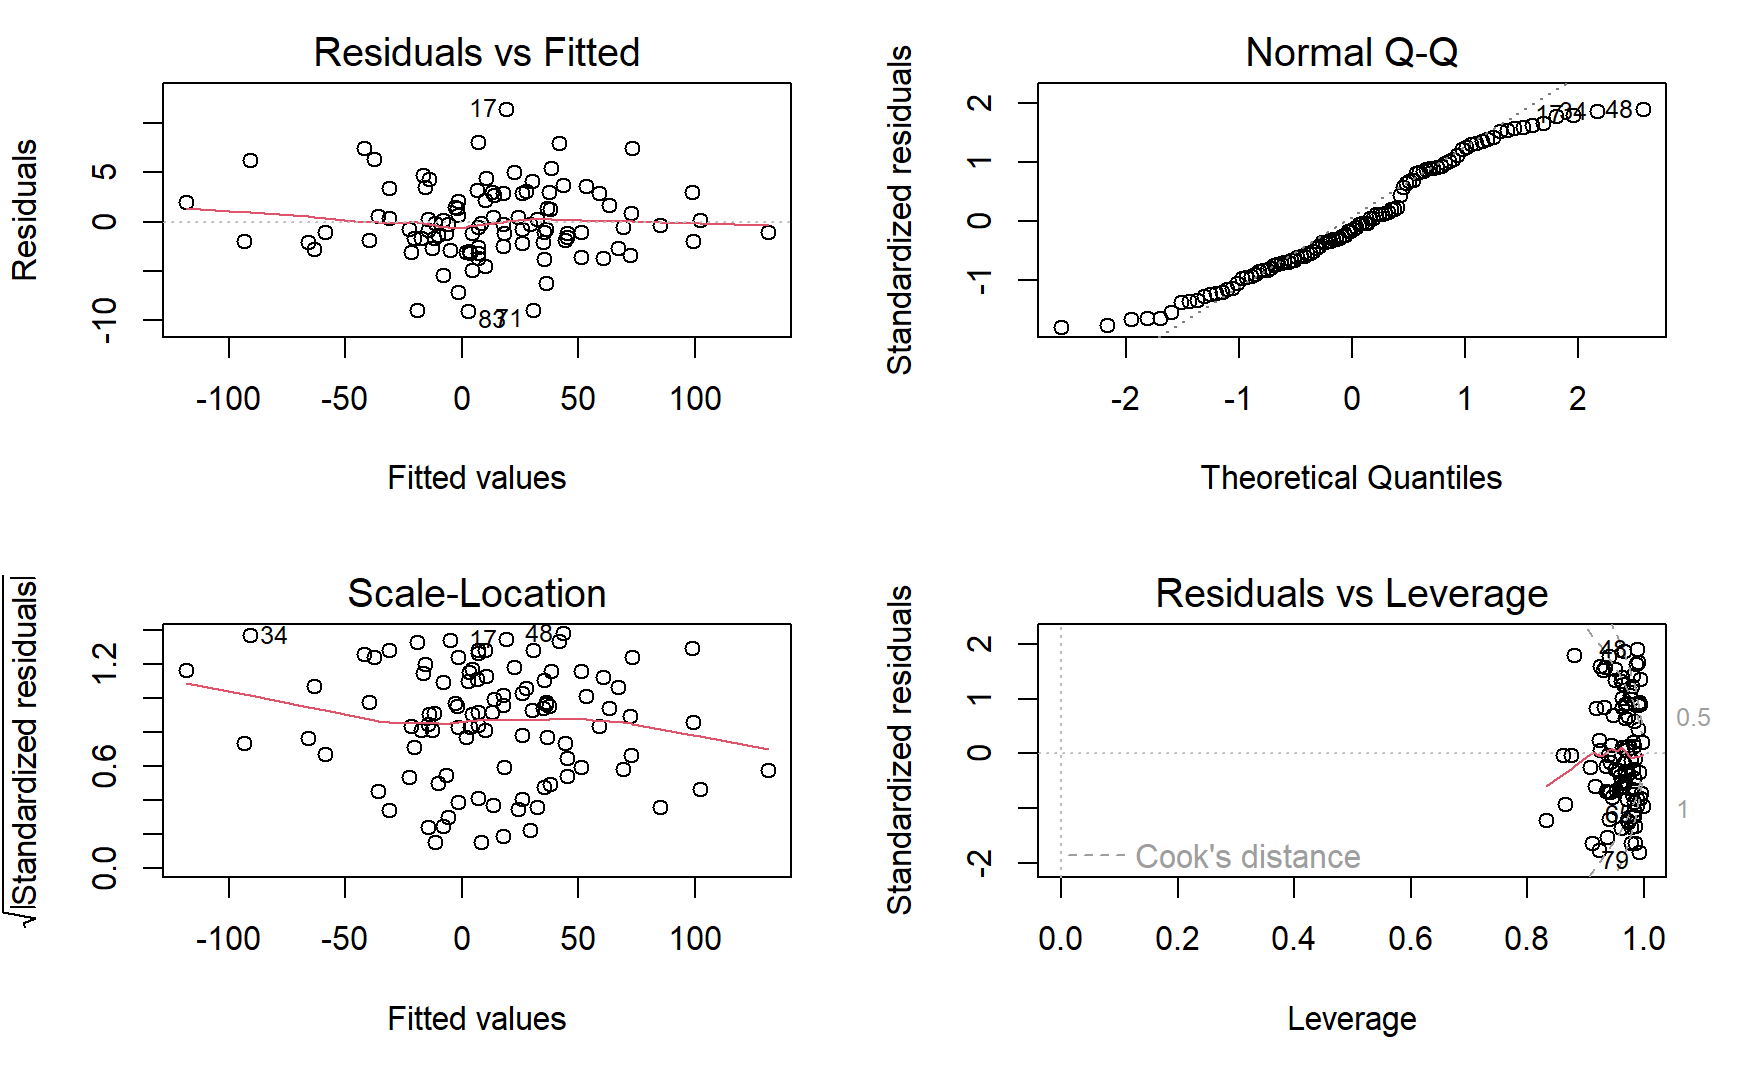

Model Selection

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Define the Hyperparameters and Models to Search Over
models = {
  'Ridge Regression': {
    'model': Ridge(),
    'param_dist': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
  },
  'Lasso Regression': {
    'model': Lasso(),
    'param_dist': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
  },
  'Elastic Net': {
    'model': ElasticNet(),
    'param_dist': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]}
  },
  'Bayesian Ridge Regression': {
    'model': BayesianRidge(),
    'param_dist': {'alpha_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3], 'alpha_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3], 'lambda_1': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3], 'lambda_2': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]}
  },
  'Linear Regression': {
    'model': LinearRegression(),
    'param_dist': {}
  },
  'KNN': {
    'model': KNeighborsRegressor(),
    'param_dist': {'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance']}
  },
  'Random Forest': {
    'model': RandomForestRegressor(),
    'param_dist': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 10]}
  },
  'Decision Tree': {
    'model': DecisionTreeRegressor(),
    'param_dist': {'max_depth': [None, 3, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
  }
} 

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import metrics

# Define the number of iterations for the cross-validation procedure
M = 5
# Create lists to store results 
model_names = []
model_test_errors = []
mean_epe_scores = []
epe_std_errors = []
model_mean_errors = {}
model_stds_errors = {}

# Define the pre-processing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.9))
])

# Initialize Summary Table
model_summary_table = pd.DataFrame(columns=['Model Name', 'Mean Test Error', 'Std Test Error'])
model_summary_table_pct = pd.DataFrame(columns=['Model Name', 'Train Error %', 'Validation Error %', 'Test Error %'])

table_rows = []
best_epe_scores = {}
best_params_all = {}
best_params = {}

train_errors_pct = []
val_error_all = []
val_error_list = []
train_error_all = []
train_error_list = []
test_error_list = []

for model_name in models.keys():
    best_epe_scores[model_name] = []
    best_params_all[model_name] = []
    best_params[model_name] = {}

# Loop over the models
for model_name, model_info in models.items():
    model = model_info['model']
    param_dist = model_info['param_dist']
    model_names.append(model_name)

    errors = []
    train_errors = []
    val_errors = []
    test_errors = []
    test_error_pct = []

    for m in range(M):

        # Randomize data (permute)
        idx = np.random.permutation(len(X))
        X_permuted = X.iloc[idx]
        y_permuted = y.iloc[idx]
        
        # Define CV inner splits
        inner_splits = 5
        inner_cv = KFold(n_splits=inner_splits, shuffle=True, random_state=m)

        # Split data in 3 (train, validation, test)
        X_train_val, X_test, y_train_val, y_test = train_test_split(X_permuted, y_permuted, test_size=0.2, random_state=m)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=m)

        best_epe_score = np.inf
        best_model = None
        best_model_loop = None
        best_params_loop = None
        val_error_pct = []
        train_error_pct = []

        # Perform grid search over hyperparameters and calculate EPE for each fold
        for train_index, val_index in inner_cv.split(X_train):
            # Split the data into training and validation sets
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            # Preprocess the training data using the pre-processing pipeline defined earlier
            X_train_imputed = preprocessing_pipeline['imputer'].fit_transform(X_train_fold.iloc[:, 0:94])
            X_train_mode_cat = preprocessing_pipeline['imputer_cat'].fit_transform(X_train_fold.iloc[:, -5:])
            X_train_onehot = preprocessing_pipeline['hot_encoder'].fit_transform(X_train_mode_cat).toarray()
            X_train_concat = pd.concat([pd.DataFrame(X_train_imputed), pd.DataFrame(X_train_onehot)], axis=1)
            X_train_array = X_train_concat.to_numpy()
            X_train_normalized = preprocessing_pipeline['scaler'].fit_transform(X_train_array)
            X_train_pca = preprocessing_pipeline['pca'].fit_transform(X_train_normalized)
            num_components = preprocessing_pipeline['pca'].n_components_  

            # Use RandomizedSearchCV for hyperparameter tuning and fitting the model on the preprocessed data
            randomized_search = RandomizedSearchCV(
                estimator=model, param_distributions=param_dist, cv=inner_cv, n_jobs=2, 
                scoring='neg_mean_squared_error', n_iter=10, random_state=m
            )
            randomized_search.fit(X_train_pca[:, :num_components], y_train_fold)
            best_model = randomized_search.best_estimator_
            best_params = randomized_search.best_params_

            # Preprocess validation data to be evaluated 
            X_val_imputed = preprocessing_pipeline['imputer'].transform(X_val_fold.iloc[:, 0:94])
            X_val_mode_cat = preprocessing_pipeline['imputer_cat'].transform(X_val_fold.iloc[:, -5:])
            X_val_onehot = preprocessing_pipeline['hot_encoder'].transform(X_val_mode_cat).toarray()
            X_val_concat = pd.concat([pd.DataFrame(X_val_imputed), pd.DataFrame(X_val_onehot)], axis=1)
            X_val_array = X_val_concat.to_numpy()
            X_val_normalized = preprocessing_pipeline['scaler'].transform(X_val_array)
            X_val_pca = preprocessing_pipeline['pca'].transform(X_val_normalized)

            # Evaluate the model on the training data
            y_pred_train = best_model.predict(X_train_pca[:, :num_components])
            train_error = mean_squared_error(y_train_fold, y_pred_train, squared=False)
            train_errors.append(train_error)

            # Evaluate the model on the validation data
            y_pred_val = best_model.predict(X_val_pca[:, :num_components])
            val_error = mean_squared_error(y_val_fold, y_pred_val, squared=False)
            val_errors.append(val_error)

            # Select best model based on validation data
            if abs(val_error) < abs(best_epe_score):
                best_epe_score = val_error
                best_model_loop = model
                best_params_loop = best_params
            
            # Calculate % Error of training and validation data
            train_error_pct.append(metrics.mean_absolute_percentage_error(y_train_fold, y_pred_train))
            val_error_pct.append(metrics.mean_absolute_percentage_error(y_val_fold, y_pred_val))

        train_error_all.append(np.mean(train_error_pct))
        val_error_all.append(np.mean(val_error_pct))
                                    
        # Append the best model with hyperparameters to a best scores and best parameters list     
        best_epe_scores[model_name].append(best_epe_score)
        best_params_all[model_name].append(best_params_loop)

        # Preprocessing and testing model to estimate the error on test set
        X_train_val_imputed = preprocessing_pipeline['imputer'].fit_transform(X_train_val.iloc[:,0:94])
        X_train_val_mode_cat = preprocessing_pipeline['imputer_cat'].fit_transform(X_train_val.iloc[:, -5:])
        X_train_val_onehot = preprocessing_pipeline['hot_encoder'].fit_transform(X_train_val_mode_cat).toarray()
        X_train_val_concat = pd.concat([pd.DataFrame(X_train_val_imputed), pd.DataFrame(X_train_val_onehot)], axis=1)
        X_train_val_array = X_train_val_concat.to_numpy()
        X_train_val_normalized = preprocessing_pipeline['scaler'].fit_transform(X_train_val_array)
        X_train_val_pca = preprocessing_pipeline['pca'].fit_transform(X_train_val_normalized)
        num_components = preprocessing_pipeline['pca'].n_components_  # added this line

        best_model.fit(X_train_val_pca[:, :num_components], y_train_val)

        X_test_imputed = preprocessing_pipeline['imputer'].transform(X_test.iloc[:,0:94])
        X_test_mode_cat = preprocessing_pipeline['imputer_cat'].transform(X_test.iloc[:, -5:])
        X_test_onehot = preprocessing_pipeline['hot_encoder'].transform(X_test_mode_cat).toarray()
        X_test_concat = pd.concat([pd.DataFrame(X_test_imputed), pd.DataFrame(X_test_onehot)], axis=1)
        X_test_array = X_test_concat.to_numpy()
        X_test_normalized = preprocessing_pipeline['scaler'].transform(X_test_array)
        X_test_pca = preprocessing_pipeline['pca'].transform(X_test_normalized)
        y_pred_test = best_model.predict(X_test_pca[:, :num_components])
        test_error = mean_squared_error(y_test, y_pred_test, squared=False)
        test_errors.append(test_error)
        test_error_pct.append(metrics.mean_absolute_percentage_error(y_test, y_pred_test))

    # Add the errors to the table rows
    test_error_list.append(np.mean(test_error_pct))
    train_error_list.append(np.mean(train_error_all))
    val_error_list.append(np.mean(val_error_all))  
    model_mean_errors[model_name] = np.mean(test_errors)  
    model_stds_errors[model_name] = np.std(test_errors)

from tabulate import tabulate

# Define the table headers and data rows, print out mean and std of test errors for each model
table_headers = ['Model Name', 'Train Error %', 'Validation Error %', 'Test Error %']

model_summary_table_pct = pd.DataFrame({'Model Name': model_names,
                                         'Train Error %': [f'{val:.3f}%' for val in train_error_list],
                                         'Validation Error %': [f'{val:.3f}%' for val in val_error_list],
                                         'Test Error %': [f'{val:.3f}%' for val in test_error_list]})

# Print the table using the tabulate library
print(tabulate(model_summary_table_pct, headers=table_headers, tablefmt='pretty'))

# Define the table headers and data rows, print out mean and std of test errors for each model
model_summary_table = pd.DataFrame({'Model Name': model_names,
                                     'Mean Test Error': model_mean_errors.values(),
                                     'Std Test Error': model_stds_errors.values()})
model_summary_table = model_summary_table.sort_values(by='Mean Test Error', ascending=True)
print('\n')
print(tabulate(model_summary_table, headers='keys', tablefmt='psql'))


+---+---------------------------+---------------+--------------------+--------------+
|   |        Model Name         | Train Error % | Validation Error % | Test Error % |
+---+---------------------------+---------------+--------------------+--------------+
| 0 |     Ridge Regression      |    1.841%     |       2.670%       |    1.540%    |
| 1 |     Lasso Regression      |    1.868%     |       2.555%       |    3.567%    |
| 2 |        Elastic Net        |    1.722%     |       2.351%       |    3.053%    |
| 3 | Bayesian Ridge Regression |    1.698%     |       2.551%       |    2.873%    |
| 4 |     Linear Regression     |    1.808%     |       2.665%       |    2.697%    |
| 5 |            KNN            |    1.689%     |       2.741%       |    2.234%    |
| 6 |       Random Forest       |    1.598%     |       2.700%       |    3.558%    |
| 7 |       Decision Tree       |    1.700%     |       2.918%       |    3.857%    |
+---+---------------------------+---------------+-----

In [ ]:
# Set Final Model to that with lowest mean EPE (RMSE)
for model_name, mean_error in model_mean_errors.items():
    std_error = model_stds_errors[model_name]
    table_rows.append([model_name, f'{mean_error:.3f}', f'{std_error:.3f}'])
    if mean_error < lowest_error:
        lowest_error = mean_error
        final_model_name = model_name

In [ ]:
# Find median of the 5 best sets of hyperparameters for the final model
best_params = None
best_params_median_idx = len(best_params_all[final_model_name]) // 2
best_params = best_params_all[final_model_name][best_params_median_idx]

# Retrain best final model on all data and save it with best hyperparameters
model_info = models[final_model_name]
final_model = model_info['model']
best_params_dist = model_info['param_dist']
if best_params is not None:
    final_model.set_params(**best_params)
else:
    print(f"Using default hyperparameters for {final_model_name}")

# Retrain best final model on all data and save it with best hyperparameters
X_imputed = preprocessing_pipeline['imputer'].fit_transform(X.iloc[:,0:94])
X_mode_cat = preprocessing_pipeline['imputer_cat'].fit_transform(X.iloc[:, -5:])
X_onehot = preprocessing_pipeline['hot_encoder'].fit_transform(X_mode_cat).toarray()
X_concat = pd.concat([pd.DataFrame(X_imputed), pd.DataFrame(X_onehot)], axis=1)
X_array = X_concat.to_numpy()
X_normalized = preprocessing_pipeline['scaler'].fit_transform(X_array)
X_pca = preprocessing_pipeline['pca'].fit_transform(X_normalized)
num_components = preprocessing_pipeline['pca'].n_components_
final_model.fit(X_pca[:, :num_components], y)

BayesianRidge(alpha_1=0.0001, alpha_2=1e-05, lambda_1=0.001, lambda_2=1e-05)

Model Assessment - Bootstrapping

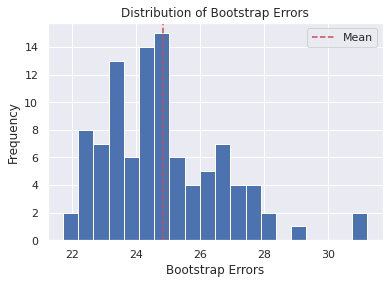

Bayesian Ridge Regression Model: BayesianRidge(alpha_1=0.0001, alpha_2=1e-05, lambda_1=0.001, lambda_2=1e-05) 	 Mean Bootstrap Error (RMSE): 24.830


In [4]:
from sklearn.utils import resample
# Set the final_model to BayesianRidge with specified parameters
final_model = BayesianRidge(alpha_1=0.0001, alpha_2=1e-05, lambda_1=0.001, lambda_2=1e-05)

# Define the pre-processing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('hot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.9))
])

# Preprocess the entire dataset using the pre-processing pipeline
X_imputed = preprocessing_pipeline['imputer'].fit_transform(X.iloc[:,0:94])
X_mode_cat = preprocessing_pipeline['imputer_cat'].fit_transform(X.iloc[:, -5:])
X_onehot = preprocessing_pipeline['hot_encoder'].fit_transform(X_mode_cat).toarray()
X_concat = pd.concat([pd.DataFrame(X_imputed), pd.DataFrame(X_onehot)], axis=1)
X_array = X_concat.to_numpy()
X_normalized = preprocessing_pipeline['scaler'].fit_transform(X_array)
X_pca = preprocessing_pipeline['pca'].fit_transform(X_normalized)
num_components = preprocessing_pipeline['pca'].n_components_

# Define the number of bootstrap iterations
B = 100

# Create a list to store the bootstrap errors 
bootstrap_errors = []

# Fit final model on pre-processed data
final_model.fit(X_pca[:, :num_components], y)

# Generate bootstrap samples and fit the model to each sample
for i in range(B):
    X_boot, y_boot = resample(X_pca[:, :num_components], y, random_state=i)
    final_model.fit(X_boot, y_boot)
    y_pred = final_model.predict(X_pca[:, :num_components])
    error = mean_squared_error(y, y_pred, squared=False)
    bootstrap_errors.append(error)

# Calculate the mean bootstrap error
mean_bootstrap_error = np.mean(bootstrap_errors)

# Plot distribution of bootstrap errors
plt.hist(bootstrap_errors, bins=20)
plt.axvline(x=mean_bootstrap_error, color='r', linestyle='--', label='Mean')
plt.xlabel('Bootstrap Errors')
plt.ylabel('Frequency')
plt.title('Distribution of Bootstrap Errors')
plt.legend()
plt.show()

# Print mean bootstrap error
print(f'Bayesian Ridge Regression Model: {final_model} \t Mean Bootstrap Error (RMSE): {mean_bootstrap_error:.3f}')


Y_New Predictions

In [8]:
# Load the data
case1Pathnew = './Comp Data Analysis/Case 1/case1Data_Xnew.txt'
df_new = pd.read_csv(case1Pathnew, na_values=['NA',' NaN','NaN','nan','n.a.'], low_memory=False)

# Get the target variable and continuous features
X_cont_new = df_new.iloc[:, 0:95]

# Get the categorical features and select the last 5 columns
X_categ_new = df_new.iloc[:, 95:100]

# Combine the continuous and categorical features
X_new = pd.concat([X_cont_new, X_categ_new], axis=1)

In [9]:
# Define the test set for the new data
X_new = X_new.rename(columns={'x_ 1': ' x_ 1'})
X_new_imputed = preprocessing_pipeline['imputer'].transform(X_new.iloc[:,0:94])
X_new_mode_cat = preprocessing_pipeline['imputer_cat'].transform(X_new.iloc[:, -5:])
X_new_onehot = preprocessing_pipeline['hot_encoder'].transform(X_new_mode_cat).toarray()
X_new_concat = pd.concat([pd.DataFrame(X_new_imputed), pd.DataFrame(X_new_onehot)], axis=1)
X_new_array = X_new_concat.to_numpy()
X_new_normalized = preprocessing_pipeline['scaler'].transform(X_new_array)
X_new_pca = preprocessing_pipeline['pca'].transform(X_new_normalized)
num_components = preprocessing_pipeline['pca'].n_components_

# Predict y values for new data
y_new_pred = final_model.predict(X_new_pca[:, :num_components])

# Save the predictions to a text file
np.savetxt("predictions_s222445s222681.txt", y_new_pred)

Predicted RMSE on New Set of X 

In [13]:
from sklearn.model_selection import cross_val_score, KFold

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=40)

# Perform k-fold cross-validation on your Bayesian Ridge Regression model
X_imputed = preprocessing_pipeline['imputer'].fit_transform(X.iloc[:,0:94])
X_mode_cat = preprocessing_pipeline['imputer_cat'].fit_transform(X.iloc[:, -5:])
X_onehot = preprocessing_pipeline['hot_encoder'].fit_transform(X_mode_cat).toarray()
X_concat = pd.concat([pd.DataFrame(X_imputed), pd.DataFrame(X_onehot)], axis=1)
X_array = X_concat.to_numpy()
X_normalized = preprocessing_pipeline['scaler'].fit_transform(X_array)
X_pca = preprocessing_pipeline['pca'].fit_transform(X_normalized)
num_components = preprocessing_pipeline['pca'].n_components_
cv_scores = cross_val_score(final_model, X_pca, y, cv=kf, scoring='neg_root_mean_squared_error')

# Calculate average RMSE across the folds
average_rmse = -np.mean(cv_scores)
std_rmse = np.std(cv_scores)

print(f"Estimated RMSE (using 5-fold cross-validation): {average_rmse:.3f} ± {std_rmse:.3f}")

# Save the predictions to a text file
average_rmse = np.array([average_rmse])
np.savetxt("estimatedRMSE_s222445s222681.txt", average_rmse)


Estimated RMSE (using 5-fold cross-validation): 27.310 ± 6.682
